In [195]:
import pandas as pd
from corre import  CorrMtx
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tseries_processing as ts
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import numpy as np
from scipy.stats import pearsonr

In [196]:
def eliminar_autocorr(df,dep,corr_max=0.50):
    ind=df.copy()
    a_eliminar=[]
    for variable_1 in ind.columns:
        for variable_2 in ind.columns:
            #print('Variable 1: ',variable_1,' y Variable 2: ',variable_2)
            #print(pearsonr(ind[variable_1],ind[variable_2]))
            #print('Correlacion de la variable 1 con gasto: ',pearsonr(ind[variable_1],ind['GastProvCarteraInd']))
            #print('Correlacion de la variable 2 con gasto: ',pearsonr(ind[variable_2],ind['GastProvCarteraInd']))
            try:
                if  pearsonr(ind[variable_1],ind[variable_2])[0]>corr_max and variable_1 != variable_2  and (variable_1 != dep and variable_2 != dep):
                    if abs(pearsonr(ind[variable_1],ind[dep])[0]) > abs(pearsonr(ind[variable_2],ind[dep])[0]):       
                        print('A eliminar: ',variable_2)
                        print('Por: ',variable_1)
                        print('Correlación de: ',pearsonr(ind[variable_1],ind[variable_2])[0])
                        a_eliminar.append(variable_2)
                    else:
                        print('A eliminar: ',variable_1)
                        print('Por: ',variable_2)
                        print('Correlación de: ',pearsonr(ind[variable_1],ind[variable_2])[0])
                        a_eliminar.append(variable_1)
            except:
                pass
    a_eliminar=pd.Series(a_eliminar)
    a_eliminar= a_eliminar.unique()
    return a_eliminar

In [197]:
plt.rcParams["figure.figsize"] = (20,20)

# <<< Crédito Grupal >>>

In [198]:
gru=pd.read_csv('gru.csv')

In [199]:
gru=gru[gru['Fecha ']!= 'Ene.2020']

In [200]:
gru.set_index('Fecha ',inplace=True)

In [201]:
gru.drop(['SaldoTotalGrupalMN','ProvisionGrupalMN','SaldoCastigadoGrupalMN','GastoProvGru'],axis=1,inplace=True)

In [202]:
gru.dropna(inplace=True)

In [203]:
for variable in gru.columns:
    gru[variable]=pd.to_numeric(gru[variable])

# Matriz correlaciones individuales

In [204]:
corr=[]
p=[]
var=[]
for variable in gru.columns:
    try:
        var.append(variable)
        corr.append(pearsonr(gru[variable],gru['GastProvCarteraGru'])[0])
        p.append(pearsonr(gru[variable],gru['GastProvCarteraGru'])[1])
    except:
        pass

dat=pd.DataFrame()
dat['variables']=var
dat['corr']=corr
dat['p']=p

In [205]:
dat

,variables,corr,p
0,credito_sector_privado,-0.139548,0.515471
1,DIsI_avg_12,-0.197189,0.355712
2,DIcP_avg_12,-0.115619,0.590587
3,inflacion,0.386108,0.062381
4,TC,0.252830,0.233272
5,tasa_ref,-0.327785,0.117900
6,PBI_avg_12,-0.310281,0.140046
7,Confianza Consumidor,-0.227960,0.284017
8,TIAPSF,-0.234190,0.270701
9,consumo _cemento,0.264054,0.212467


# Eliminando correlación no significactiva 

In [206]:
a_eliminar=[]
for variable in gru.columns:
    try:
        if  pearsonr(gru[variable],gru['GastProvCarteraGru'])[1]>0.15:
            a_eliminar.append(variable)
    except:
        pass
print('Variables a eliminar: ',a_eliminar)

Variables a eliminar:  ['credito_sector_privado', 'DIsI_avg_12', 'DIcP_avg_12', 'TC', 'Confianza Consumidor', 'TIAPSF', 'consumo _cemento', 'exportaciones', 'Pesca', 'Minerí\xada_hidrocarburos', 'Manufactura', 'Electricidad', 'Construcción', 'Comercio', 'Otros_servicios']


In [207]:
gru.drop(a_eliminar,axis=1,inplace=True)

In [208]:
gru.columns

Index(['inflacion', 'tasa_ref', 'PBI_avg_12', 'EMBIG', 'Agropecuario',
       'GastProvCarteraGru'],
      dtype='object')

In [209]:
gru.drop(['tasa_ref','EMBIG','Agropecuario'],axis=1 , inplace=True)

# Rezagando

Eligiendo variable con el mejor rezago 

In [210]:

def analisis_rezagos(df,n_rezagos,dep,dicc):
    variables_a_analizar=df.columns
    ind=df.copy()
    ind=ts.rezagar(ind,n_rezagos,diferencias=False)
    ind.dropna(inplace=True)
    #print(ind.columns)

    variables=[]
    mejores_rezagos=[]
    r2s=[]
    rs=[]
    for variable in variables_a_analizar:
        r2_max=0
        mejor_rezago = 0 
        r_max=0
        for rezago in range(0,n_rezagos):
            if rezago == 0:
                r=pearsonr(ind[variable],ind[dep])[0]
                r2 = pearsonr(ind[variable],ind[dep])[0]**2
                #print('Variable ',variable,' con rezago ',rezago,' tiene un R2 de ',r2)
            else:
                r=pearsonr(ind['_'+str(rezago)+variable],ind[dep])[0]
                r2 = pearsonr(ind['_'+str(rezago)+variable],ind[dep])[0]**2
                #print('Variable ',variable,' con rezago ',rezago,' tiene un R2 de ',r2)

            if r2 >r2_max:
                r2_max=r2
                mejor_rezago=rezago
                r_max=r
                

        variables.append(variable)
        mejores_rezagos.append(mejor_rezago)
        r2s.append(r2_max)
        rs.append(r_max)

    cuadro=pd.DataFrame()
    cuadro['variables']=variables
    cuadro['rezagos']=mejores_rezagos
    cuadro['r2s']=r2s
    cuadro['rs']=rs
    cuadro.columns=['variable','rezago','r2','r']
    
    
    
    '''  Graficos '''
    cuadro2=cuadro.copy()
    cuadro2['rezago']=cuadro2['rezago'].astype(str)
    cuadro2['rezago'] = cuadro2['rezago'].apply( lambda x: '' if  x == '0' else '_'+x )
    cuadro2['var'] = cuadro2['rezago'] + cuadro2['variable']
    var=cuadro2['var'].tolist()
      
    titles=var
     
    y_vals=[]
    for i in ind.columns:
        y_vals.append(ind[i])
        
    x=ind['GastProvCarteraGru']

    
    fig, axes = plt.subplots(nrows=2, ncols=2)


    for ax, title, y in zip(axes.flat, titles, y_vals):
        #print(ax,title,y)
        m, b = np.polyfit(y,x, 1)
        ax.plot(y,m*y + b)
        ax.plot(y, x,'o')
        ax.legend(round(cuadro[cuadro2['var']==title]['r2'],2))           
        ax.set_title(title+'\n Eq: '+str(round(m,6))+'*X1 + '+str(round(b,6)),fontsize=15)
        ax.grid(True)
        
        #print('--------',title,'--------')
        #print('Gasto de provision sobre cartera en t: ',m*dicc[title]+b)
        #print('Gasto de provision en millones S/. : ',( (m*dicc[title]+b)* 683325886.00)/1000000.00 ) 
        #print('Gasto de provision sobre cartera proemdio: ',( (m*dicc[title]+b)* 564273855.00)/ 2205830786.36 )    

    # Saldo de cartera final 2020 : 2451225608.99
    #Promedio de cartera 2020 : 2205830786.36 
    
    
    ind= ind[titles] # Filtrando solo los campos seleccionados 
 


    return cuadro,ind

In [211]:
dicc = {'_2inflacion':2,'_3TC':3.51,'PBI_avg_12':2.70,'GastProvCarteraGru':5.39,'TIAPSF':14.08,'exportaciones':1000,'EMBIG':1.16,'_3Manufactura':1.77,'_2Construcción':1.54}

,variable,rezago,r2,r
0,inflacion,2,0.282956,0.531936
1,PBI_avg_12,0,0.428817,-0.654841
2,GastProvCarteraGru,0,1.000000,1.000000


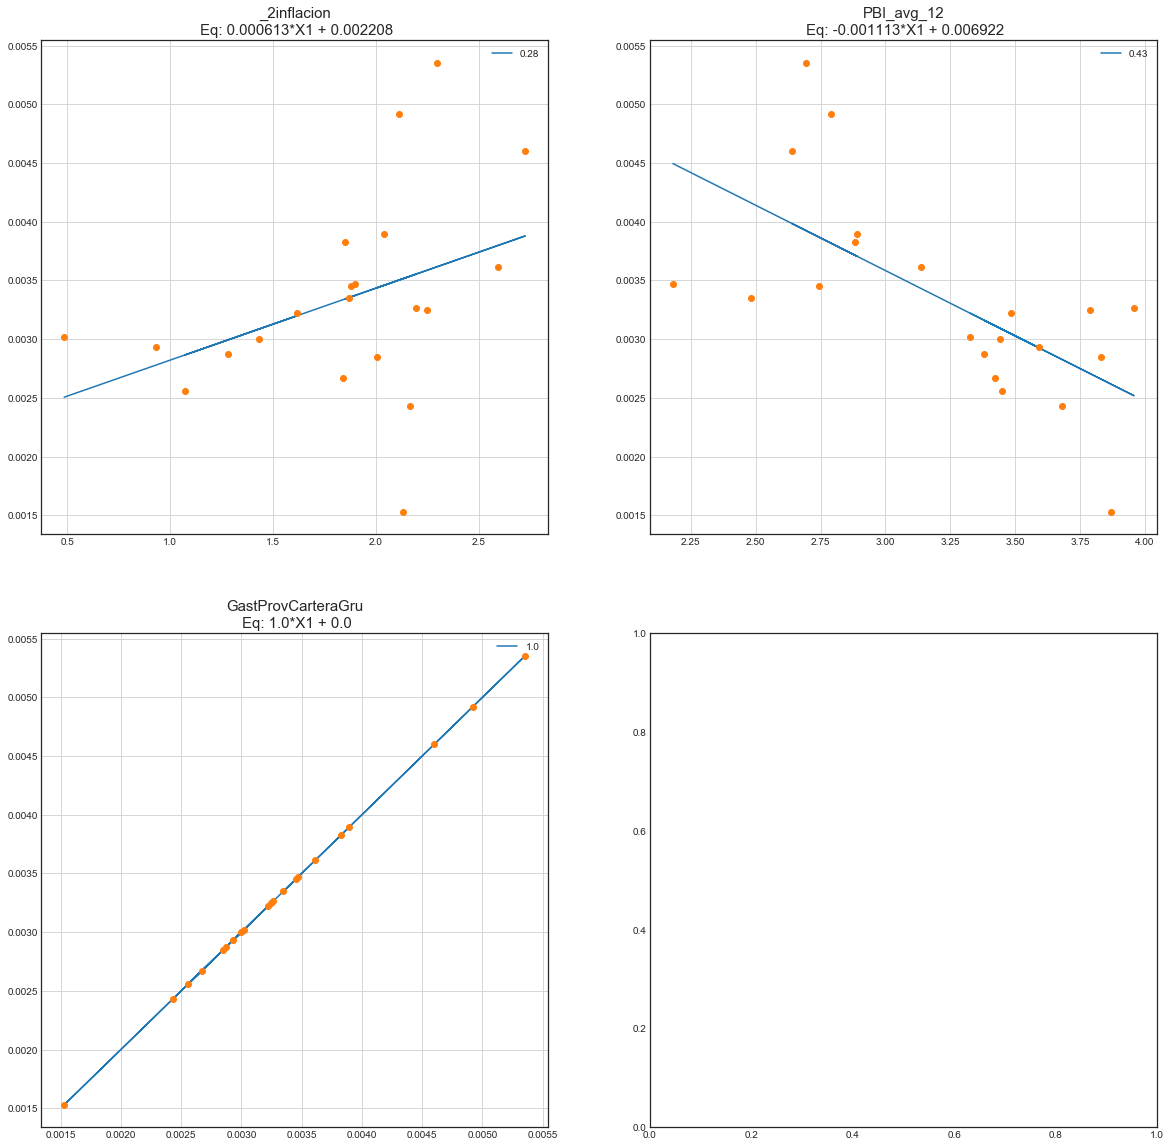

In [212]:
cuadro,gru=analisis_rezagos(gru,4,dep='GastProvCarteraGru',dicc= dicc)
cuadro

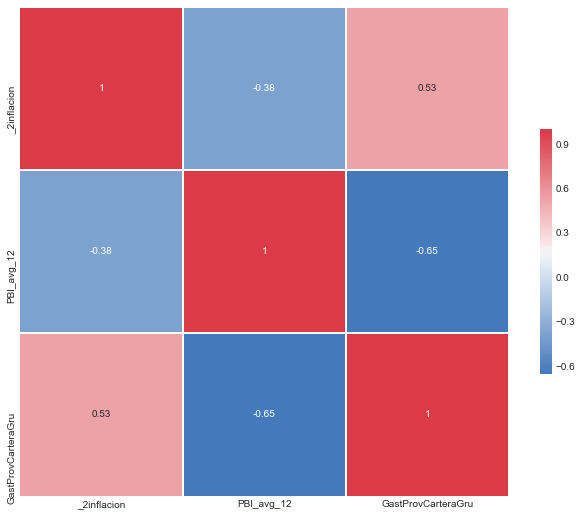

In [213]:
 CorrMtx(gru)

In [214]:
y=gru['GastProvCarteraGru']
X=gru.copy()
X.drop('GastProvCarteraGru',axis=1,inplace=True)

In [215]:
X= sm.add_constant(X)
mod = sm.OLS(y, X)
res = mod.fit(cov_type='HC3')
print(res.summary())   #modelo que queda 

                            OLS Regression Results                            
Dep. Variable:     GastProvCarteraGru   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     5.870
Date:                Wed, 11 Mar 2020   Prob (F-statistic):             0.0109
Time:                        17:24:13   Log-Likelihood:                 126.64
No. Observations:                  21   AIC:                            -247.3
Df Residuals:                      18   BIC:                            -244.2
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0055      0.002      2.961      

C:\Users\jcondori\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [216]:
res,X=ts.back_elimination(y,X,alpha=0.10)

                            OLS Regression Results                            
Dep. Variable:     GastProvCarteraGru   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     6.453
Date:                Wed, 11 Mar 2020   Prob (F-statistic):             0.0200
Time:                        17:25:11   Log-Likelihood:                 124.80
No. Observations:                  21   AIC:                            -245.6
Df Residuals:                      19   BIC:                            -243.5
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0069      0.001      4.670      0.0

C:\Users\jcondori\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


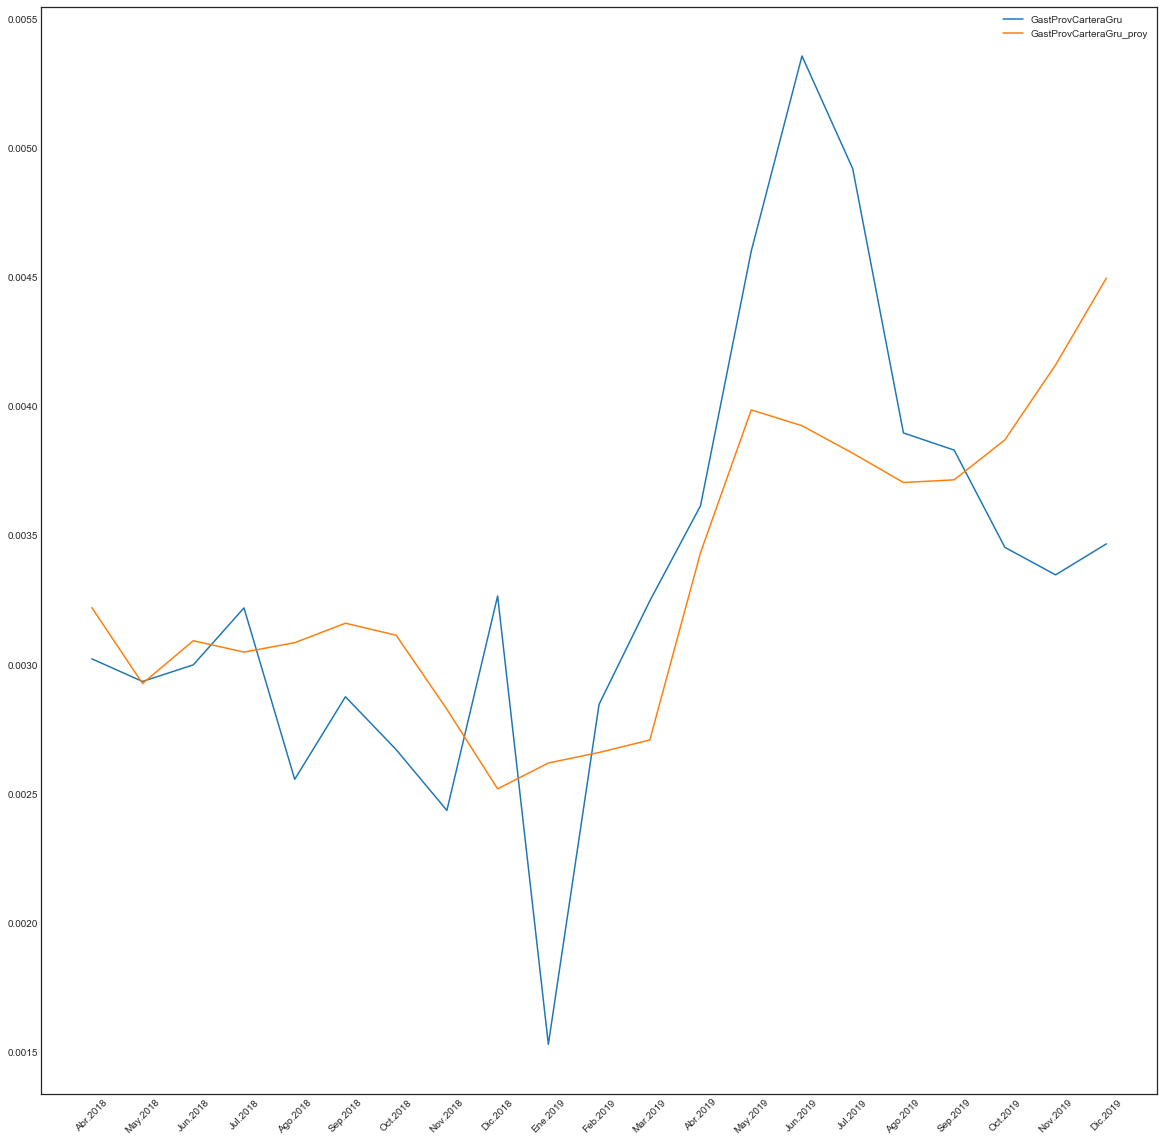

In [218]:
gru['GastProvCarteraGru_proy']=res.predict()

plt.plot(gru['GastProvCarteraGru'])
plt.plot(gru['GastProvCarteraGru_proy'])
plt.xticks(rotation=45)
plt.legend()

----------Durbin Watson-------------
Durbin Watson is: 1.1245425553107677


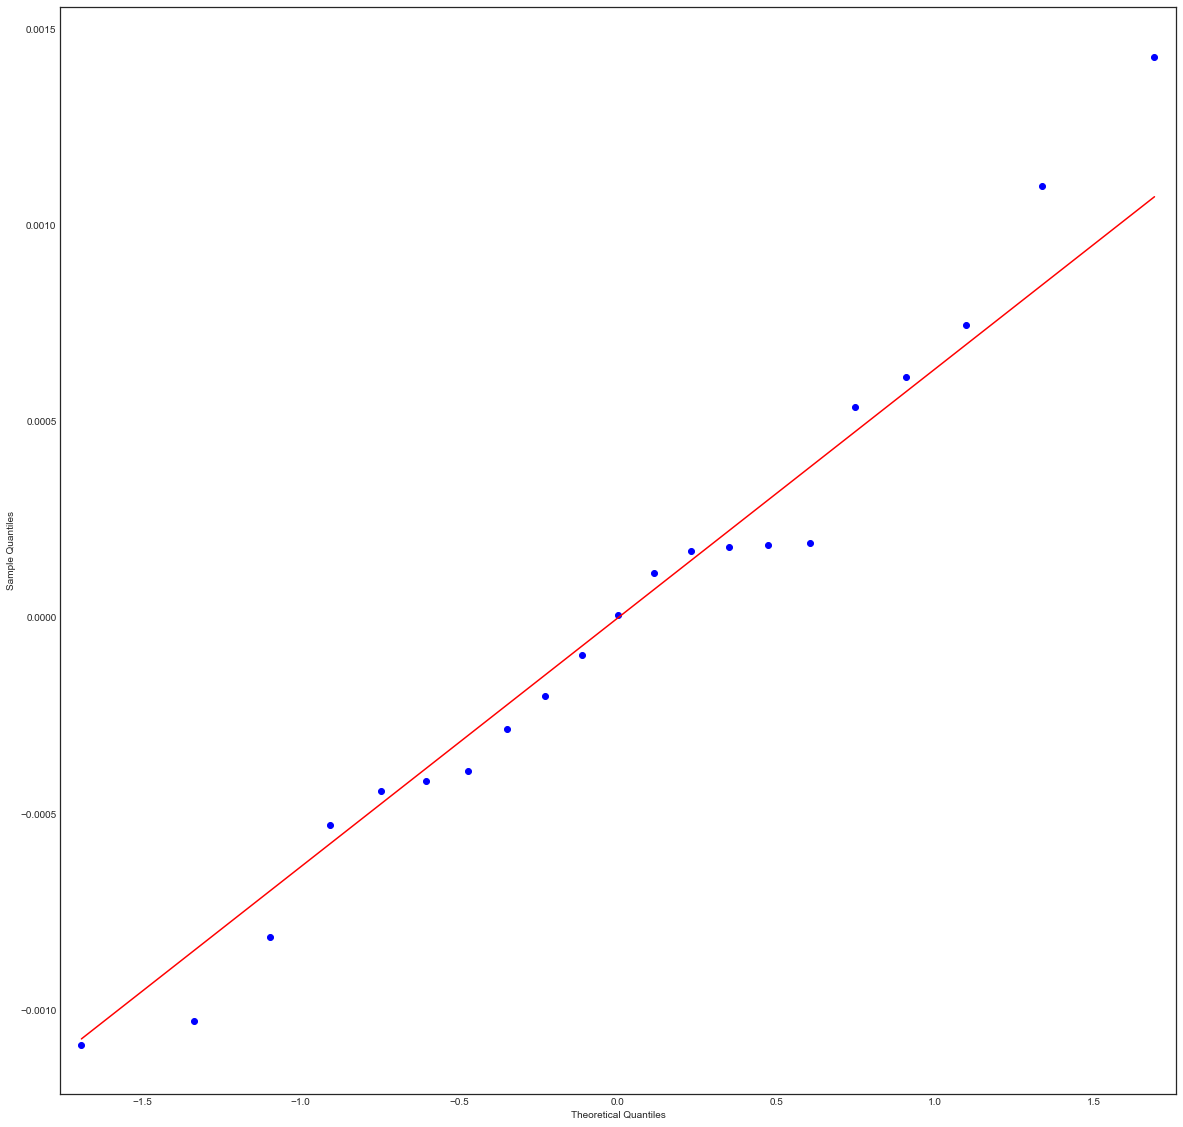

--------Breusch Autocorr-----------
lm: 16.510356330525454
lmpval: 0.1689625299469962
fval: 2.1451682810127517
fpval: 0.15891118178222513
Not Evidence for autocorrelation
-----White Heteroskedasticity------
{'LM Statistic': 5.9278700789381675, 'LM-Test p-value': 0.051615408358617096, 'F-Statistic': 3.5397008246253856, 'F-Test p-value': 0.050535667792513735}
Not Evidence for heteroskedasticity
----------ADF Test-----------------


C:\Users\jcondori\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


ADF Statistic: -0.0
p-value: 0.958532086060056
Critical Values:
	1%: -4.223238279489106
	5%: -3.189368925619835
	10%: -2.729839421487603
Conclusion : Non stationary
----------Shapiro Normality--------
Statistics=0.975, p=0.845
Sample looks Gaussian (fail to reject H0)


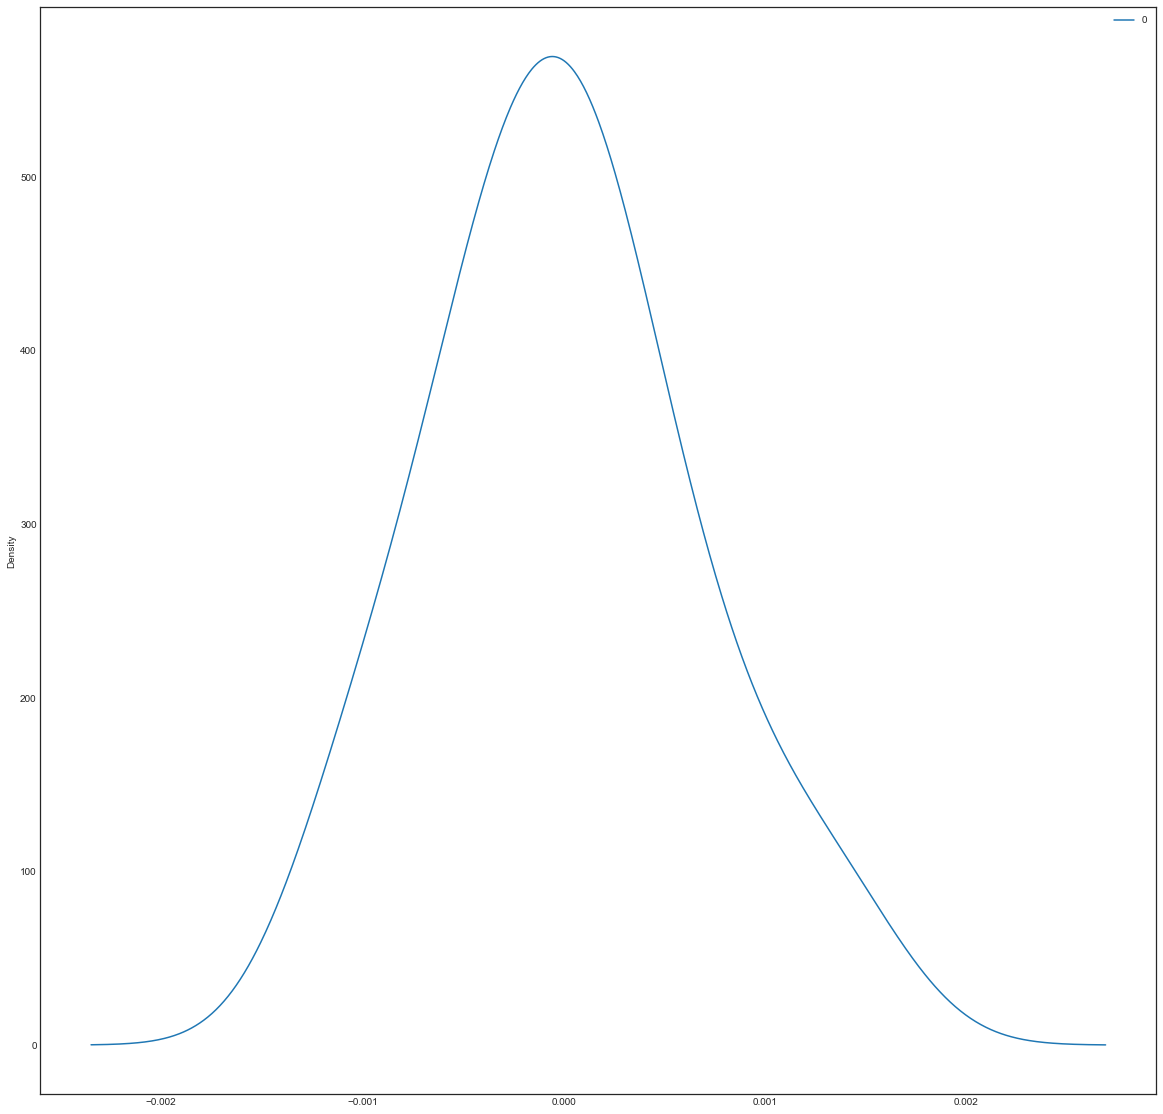

In [219]:
ts.error_analisis(res,plot=True)